# Create statistical features num_words, TTR, LTR and MTR for N1904-TF

## Table of content (ToC)<a class="anchor" id="TOC"></a>

* <a href="#bullet1">1 - Introduction</a>
* <a href="#bullet2">2 - Load the N1904-TF dataset</a>
* <a href="#bullet3">3 - Create the features</a>    
  * <a href="#bullet3x1">3.1 - Create num_words data</a>
  * <a href="#bullet3x2">3.2 - Create TTR, LTR and MTR data</a>
  * <a href="#bullet3x3">3.3 - Create the metadata</a>
  * <a href="#bullet3x4">3.4 - Link feature data to metadata</a>
  * <a href="#bullet3x5">3.5 - Save the features to file</a>
  * <a href="#bullet3x6">3.6 - Reload Text-Fabric with the new features</a>
  * <a href="#bullet3x7">3.7 - Check if the new features are loaded</a>
  * <a href="#bullet3x8">3.8 - Save the newly created features</a>
* <a href="#bullet4">4 - Make some plots</a>
* <a href="#bullet5">5 - Required libraries</a>
* <a href="#bullet6">6 - Attribution and footnotes</a>
* <a href="#bullet7">7 - Notebook version</a>

# 1 - Introduction <a class="anchor" id="bullet1"></a>
##### [Back to ToC](#TOC)

This notebook was initialy intended to quicly create statistic features `num_words` for N1904-TF.
That seems kind of a trivial feature, but it simplifies some of the statistic analysises I wanted to run.

This second version of the Jupyter Notebook adds the features TTR, LTR and MTR.
All new features will be added to [N1904Addons](https://tonyjurg.github.io/N1904addons/features/#feature-group-statistic) under the 'statistic' group.

# 2 - Load the N1904-TF dataset <a class="anchor" id="bullet2"></a>
##### [Back to ToC](#TOC)

In this case we initialy only need the base dataset.

In [1]:
# Load the autoreload extension to automatically reload modules before executing code
%load_ext autoreload
%autoreload 2

In [2]:
from tf.fabric import Fabric
from tf.app import use

In [3]:
# load the N1904 app and data
N1904 = use ("CenterBLC/N1904", version="1.0.0", silence="terse", hoist=globals() )

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

In [4]:
# The following will push the Text-Fabric stylesheet to this notebook (to facilitate proper display with notebook viewer)
N1904.dh(N1904.getCss())

# 3 - Create the features <a class="anchor" id="bullet3"></a>
##### [Back to ToC](#TOC)

## 3.1 - Create num_words data <a class="anchor" id="bullet3x1"></a>

This is basicly a simple loop over all nodetypes except word and count all descendant word nodes.

In [5]:
# List of node types to process, which is basicly all except for word nodes
nodeTypes = ['book', 'chapter', 'verse', 'sentence', 'group', 'wg', 'phrase', 'subphrase', 'clause']

# Flat dictionary: key = node id, value = number of word descendants
num_words_Dict = {}

for nodeType in nodeTypes:
    for node in F.otype.s(nodeType):
        num_words_Dict[node] = len(L.d(node, otype='word'))

print('finished')

finished


## 3.2 - Create TTR, LTR, and MTR  data <a class="anchor" id="bullet3x2"></a>

The idea is to define 3 Type-to-Token Ratios, each expressing a different abstraction. I want to calculate this for each `group`, `wg`, `phrase`, `subphrase`, `clause`, `sentence`, `chapter` and `book` node in the N1904-TF. Note that `verse` does not realy make sense in this context, as it is not a real linguistic unit.

The math is simple. Take for instance a segment of text consisting of $N$ tokens (in N1904-TF context that would be `word` nodes). Now we can define:

The classic Text-to-Token Ratio (TTR), which measures raw word-form diversity:

$$
    \text{TTR} 
    = \frac{|\{\text{unique word‐forms in text}\}|}{N} \tag{1}
$$

This we can augment with a Lemma-to-Token Ratio (LTR), where we measure lemma diversity:

$$
  \text{LTR} 
    = \frac{|\{\text{unique lemmas in the text}\}|}{N} \tag{2}
$$

And the third one would be the Morph-to-Token Ratio (MTR) where I cound distinct morphological tags as indicative for morphological diversity.

$$
    \text{MTR} 
    = \frac{|\{\text{unique morph-tags in the text}\}|}{N} \tag{3}
$$

These TTR's I would like to use as complement to the earlier created text, lemma and morph entropy features. So I will use similair naming converions (not TTR,LTR and MTR) for these new features.


In [6]:
# List of node types to process, which is basicly all except for word nodes
nodeTypes = ['book', 'chapter', 'verse', 'sentence', 'group', 'wg', 'phrase', 'subphrase' 'clause']

# Flat dictionary: key = node id, value = the ratio
ttr_Dict = {}
ltr_Dict = {}
mtr_Dict = {}

for nodeType in nodeTypes:
    for node in F.otype.s(nodeType):
        wordNodeList = L.d(node, otype='word')
        num_words=len(wordNodeList)
        # initialize a sets for word_form, lemma and morph
        seen_word_forms=set()
        seen_lemmas=set()
        seen_morphs=set()
        for wordNode in wordNodeList:
            word_form = F.text.v(wordNode).lower() # ignore capitals
            if word_form not in seen_word_forms:
                seen_word_forms.add(word_form)
            lemma = F.lemma.v(wordNode)
            if lemma not in seen_lemmas:
                seen_lemmas.add(lemma)
            morph = F.morph.v(wordNode)
            if morph not in seen_morphs:
                seen_morphs.add(morph)
        num_unique_word_forms=len(seen_word_forms)
        ttr_Dict[node]=str(num_unique_word_forms/num_words)[:10]
        num_unique_lemmas=len(seen_lemmas)
        ltr_Dict[node]=str(num_unique_lemmas/num_words)[:10]
        num_unique_morphs=len(seen_morphs)
        mtr_Dict[node]=str(num_unique_morphs/num_words)[:10]
        
print('finished')         

finished


In [7]:
# Show the first 5 entries of ttr_Dict
for node, ratio in list(ttr_Dict.items())[:5]:
    print(f"Node {node} ({F.otype.v(node)}): TTR={ratio} ")

Node 137780 (book): TTR=0.22963003 
Node 137781 (book): TTR=0.26735833 
Node 137782 (book): TTR=0.25061677 
Node 137783 (book): TTR=0.18065588 
Node 137784 (book): TTR=0.26385037 


Hmmm. Interesting. The TTR for John is significant lower that for the other Gospels.... What for LTR and MTR?

In [8]:
# Show the first 5 entries of ltr_Dict
for node, ratio in list(ltr_Dict.items())[:5]:
    print(f"Node {node} ({F.otype.v(node)}): TTR={ratio} ")

Node 137780 (book): TTR=0.09126181 
Node 137781 (book): TTR=0.11847122 
Node 137782 (book): TTR=0.10438939 
Node 137783 (book): TTR=0.06539666 
Node 137784 (book): TTR=0.10966128 


In [9]:
# Show the first 5 entries of mtr_Dict
for node, ratio in list(mtr_Dict.items())[:5]:
    print(f"Node {node} ({F.otype.v(node)}): TTR={ratio} ")

Node 137780 (book): TTR=0.03142248 
Node 137781 (book): TTR=0.04416068 
Node 137782 (book): TTR=0.03268914 
Node 137783 (book): TTR=0.03292207 
Node 137784 (book): TTR=0.03457837 


## 3.3 - Create the metadata <a class="anchor" id="bullet3x3"></a>

As usual, start with a helper function to easily create Metadata for multiple features in one go (even if it is only one...).

In [10]:
# Common Text-Fabric metadata template function
def createMetadata(description,type):
    return {
        'author': 'Tony Jurg',
        'convertedBy': 'Tony Jurg',
        'website': 'https://github.com/tonyjurg/N1904addons', 
        'description': description,
        'coreData': 'Nestle 1904 Text-Fabric (centerBLC)',
        'coreDataUrl': 'https://github.com/CenterBLC/N1904',
        'provenance': 'jupyter Notebook (https://github.com/tonyjurg/create_TF_feature_betacode)',
        'version': '1.0.0',   # This is the version of the N1904-TF dataset against which this feature is build!
        'license': 'Creative Commons Attribution 4.0 International (CC BY 4.0)',
        'licenseUrl': 'https://github.com/tonyjurg/N1904addons/blob/main/LICENSE.md',
        'valueType': type
    }


Define the specifics for the feature we are going to add.

In [11]:
# Create metadata for the new features using createMetadata function
num_words_Metadata = createMetadata('Number of word nodes below this node.','int')
text_ttr_Metadata  = createMetadata('Type to Token Ratio based on wordforms for all word nodes under this node.','str')
lemma_ttr_Metadata = createMetadata('Type to Token Ratio based on lemma for all word nodes under this node.','str')
morph_ttr_Metadata = createMetadata('Type to Token Ratio based on morph for all word nodes under this node.','str')

Let us now first check if it all stitches together properly.

In [12]:
num_words_Metadata

{'author': 'Tony Jurg',
 'convertedBy': 'Tony Jurg',
 'website': 'https://github.com/tonyjurg/N1904addons',
 'description': 'Number of word nodes below this node.',
 'coreData': 'Nestle 1904 Text-Fabric (centerBLC)',
 'coreDataUrl': 'https://github.com/CenterBLC/N1904',
 'provenance': 'jupyter Notebook (https://github.com/tonyjurg/create_TF_feature_betacode)',
 'version': '1.0.0',
 'license': 'Creative Commons Attribution 4.0 International (CC BY 4.0)',
 'licenseUrl': 'https://github.com/tonyjurg/N1904addons/blob/main/LICENSE.md',
 'valueType': 'int'}

## 3.4 - Link featuredata to metadata<a class="anchor" id="bullet3x4"></a>

Now we give the new feature its real TF name, and connect this name with the names of the related data dictionary and metadata dictionary.

In [13]:
metadata ={ 
    'num_words'    : num_words_Metadata,
    'text_ttr'     : text_ttr_Metadata,
    'lemma_ttr'    : lemma_ttr_Metadata,
    'morph_ttr'    : morph_ttr_Metadata,
}

In [14]:
nodedata = {
    'num_words'    : num_words_Dict,
    'text_ttr'     : ttr_Dict,
    'lemma_ttr'    : ltr_Dict,
    'morph_ttr'    : mtr_Dict,
}

## 3.5 - Save the features to file<a class="anchor" id="bullet3x5"></a>

Now we save the new features to threir own `.tf` file.

If you don’t pass an explicit target path, `TF.save()` writes the files to the directory that already contains the loaded corpus—in this case the local on‑disk copy of the N1904 Text‑Fabric dataset.

In [15]:
TF.save(nodeFeatures=nodedata, metaData=metadata)  # silent="terse"

  0.00s Exporting 4 node and 0 edge and 0 configuration features to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0:
   |     0.19s T lemma_ttr            to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0
   |     0.19s T morph_ttr            to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0
   |     0.32s T num_words            to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0
   |     0.19s T text_ttr             to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0
  0.90s Exported 4 node features and 0 edge features and 0 config features to ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0


True

## 3.6 - Reload Text-Fabric with the new features <a class="anchor" id="bullet3x6"></a>

Next we’ll confirm that Text‑Fabric can pick up the new features. For this we need to also load the N1904addons.

In [16]:
# load the N1904-TF app and data in another instance 
N1904_ADD = use ('CenterBLC/N1904', mod="tonyjurg/N1904addons/tf/", silent="terse")

Name,# of nodes,# slots / node,% coverage
book,27,5102.93,100
chapter,260,529.92,100
verse,7944,17.34,100
sentence,8011,17.20,100
group,8945,7.01,46
clause,42506,8.36,258
wg,106868,6.88,533
phrase,69007,1.90,95
subphrase,116178,1.60,135
word,137779,1.00,100


Display is setup for viewtype [syntax-view](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/syntax-view.md#start)

See [here](https://github.com/saulocantanhede/tfgreek2/blob/main/docs/viewtypes.md#start) for more information on viewtypes

## 3.7 - Check if the new features are loaded <a class="anchor" id="bullet3x7"></a>

This can be done easily using the 'A.isLoaded()' method:

In [17]:
N1904.isLoaded(['num_words'])

num_words            node (int) Number of word nodes below this node.


In [18]:
N1904_ADD.isLoaded(['num_words'])

num_words            node (int) Number of word nodes below this node.


## 3.8 - Save the newly created features <a class="anchor" id="bullet3x8"></a>

The last step is to obtain the newly created features from location ~/text-fabric-data/github/CenterBLC/N1904/tf/1.0.0 (see output of <a href="#bullet3x5">step 3.5</a>) and move them to its new location: https://github.com/tonyjurg/N1904addons/tree/main/tf/1.0.0.

# 4 - Make some plots<a class="anchor" id="bullet4"></a>
##### [Back to ToC](#TOC)

In order to visualize the calculated data, some simple plots can be made. The following plot compares text_ttr, lemma_ttr and morph_ttr for book nodes.

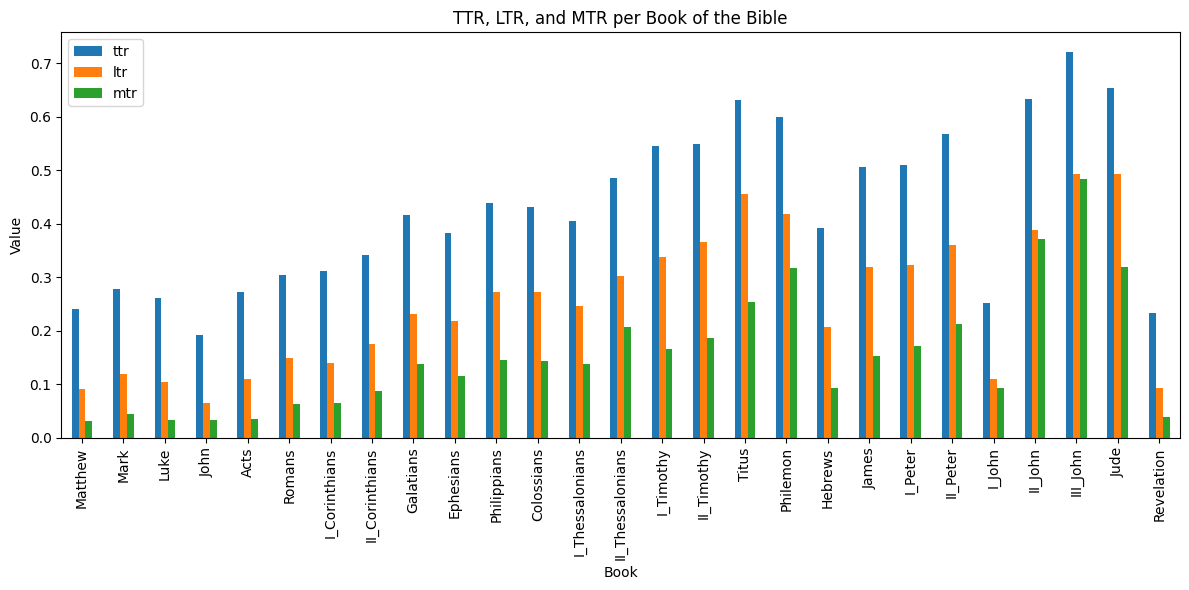

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

def main():
    # Get all book objects
    books = F.otype.s('book')
    
    # Now obtain the TTR data
    records = []
    for book in books:
        # the TTR's are stored in TF as a string reprentation of a float
        ttr = float(F.text_ttr.v(book))
        ltr = float(F.lemma_ttr.v(book))
        mtr = float(F.morph_ttr.v(book))
        name = F.book.v(book)
        records.append({'book': name, 'ttr': ttr, 'ltr': ltr, 'mtr': mtr})
    
    # Build DataFrame
    df = pd.DataFrame(records).set_index('book')
    
    # Plot
    ax = df.plot(kind='bar', figsize=(12, 6))
    ax.set_xlabel('Book')
    ax.set_ylabel('Value')
    ax.set_title('TTR, LTR, and MTR per book of the New Testament')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

**This graph raises serious alarms**

It should be normalized in some manner, as shorter books are clearly resulting in higher TTR ratios (even while TTR is already a ratio).

Going forwards, it may be a better idea to utilize the code from [github.com/lsys/LexicalRichness](https://github.com/lsys/LexicalRichness) as it provides a set of well defined feature values. (parked for now...)

# 5 - Required libraries<a class="anchor" id="bullet5"></a>
##### [Back to ToC](#TOC)

Since the scripts in this notebook utilize Text-Fabric, [it requires currently (Apr 2025) Python >=3.9.0](https://pypi.org/project/text-fabric) together with the following libraries installed in the environment (only if you want to plot):

    mathplot
    pandas
    
You can install any missing library from within Jupyter Notebook using either`pip` or `pip3`.

# 6 - Attribution and footnotes <a class="anchor" id="bullet6"></a>
##### [Back to ToC](#TOC)

Greek base text: Nestle1904 Greek New Testament, edited by Eberhard Nestle, published in 1904 by the British and Foreign Bible Society. Transcription by [Diego Santos](https://sites.google.com/site/nestle1904/home). Public domain.

The [N1904-TF dataset](https://centerblc.github.io/N1904/) available under [MIT licence](https://github.com/CenterBLC/N1904/blob/main/LICENSE.md). Formal reference: Tony Jurg, Saulo de Oliveira Cantanhêde, & Oliver Glanz. (2024). *CenterBLC/N1904: Nestle 1904 Text-Fabric data*. Zenodo. DOI: [10.5281/zenodo.13117911](https://doi.org/10.5281/zenodo.13117910).

The added features and this notebook are released under the [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://github.com/tonyjurg/Create-TF-stat-features/blob/main/LICENSE.md).

# 7 - Notebook version<a class="anchor" id="bullet7"></a>
##### [Back to ToC](#TOC)

<div style="float: left;">
  <table>
    <tr>
      <td><strong>Author</strong></td>
      <td>Tony Jurg</td>
    </tr>
    <tr>
      <td><strong>Version</strong></td>
      <td>1.2</td>
    </tr>
    <tr>
      <td><strong>Date</strong></td>
      <td>28 May 2025</td>
    </tr>
  </table>
</div>